In [2]:
import numpy as np
from env.dis_one_joint import ArmEnv
from utils.util import ReplayMemory
from matplotlib import pyplot as plt
import tntorch as tn
import torch
torch.set_default_dtype(torch.float64)
%matplotlib inline

In [5]:
EP_LEN = 50
expert_len = 50  # number of demonstration
env = ArmEnv(ep_len=EP_LEN)
obs_dim = env.observation_space
action_dim = env.action_dim
seed = 112

# load replay buffer -- state, action, reward, next_state, done
expert_buffer = ReplayMemory(seed=seed, capacity=expert_len*EP_LEN)
expert_buffer.load_buffer(f"../checkpoints/buffer_one_joint_{EP_LEN}_")
print("The length of trajectory %d" %(len(expert_buffer.start_idx)-1))
print("The length of steps %d" %(len(expert_buffer)))

Loading buffer from ../checkpoints/buffer_one_joint_500_
The length of trajectory 500
The length of steps 8057


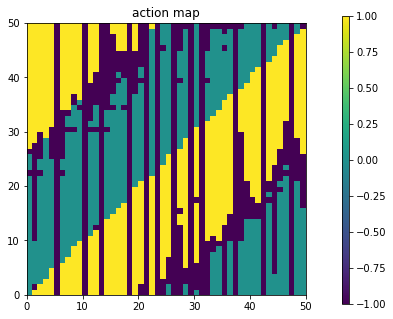

In [6]:
visit_action = np.zeros((obs_dim + [action_dim]))
len_traj = len(expert_buffer.buffer)

for i in range(len_traj):
    state = expert_buffer.buffer[i][0]
    action = expert_buffer.buffer[i][1]
    visit_action[state[0], state[1], action] +=1

unvisited_state = np.where(visit_action.sum(axis=2)==0)

# using the maximum visited time action as the selected action
best_action_map = np.argmax(visit_action, axis=2)

best_action_map[unvisited_state] = -1

fig = plt.figure(figsize=(5, 5))
plt.title('action map')
img1 = plt.pcolormesh(best_action_map)
cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img1, cax=cb_ax)

In [7]:
state_act1 = np.argwhere(best_action_map==0)
act1 = np.zeros(len(state_act1))
state_act2 = np.argwhere(best_action_map==1)
act2 = np.ones(len(state_act2))

train_state = np.concatenate((state_act1, state_act2), axis=0)
train_action = np.concatenate((act1, act2), axis=0)
print("the length of the training set is %d" %len(train_state))

idx = np.random.permutation(len(train_state))
train_state = torch.tensor(train_state[idx]).long()
train_action = torch.tensor(train_action[idx]).long()

the length of the training set is 1599


In [8]:
N = 2
t = tn.rand(obs_dim + [action_dim], ranks_tt=10, ranks_tucker=6, requires_grad=True)
t.set_factors('dct', dim=range(N))
t

3D TT-Tucker tensor:

 50  50   2
  |   |   |
  6   6   6
 (0) (1) (2)
 / \ / \ / \
1   10  10  1

In [9]:
def softmax(x):
    expx = torch.exp(x-x.max())
    return expx / torch.sum(expx, dim=-1, keepdim=True)

def cross_entropy_loss(probs, y):
    return torch.mean(-torch.log(probs[np.arange(len(probs)), y]))

def loss(t):
    return cross_entropy_loss(softmax(t[train_state].torch()), train_action)

tn.optimize(t, loss)

iter: 0       | loss:   0.775723 | total time:    0.0682
iter: 500     | loss:   0.089441 | total time:    0.8821
iter: 1000    | loss:   0.032270 | total time:    1.5898
iter: 1500    | loss:   0.021904 | total time:    2.2371
iter: 2000    | loss:   0.017826 | total time:    2.9079
iter: 2500    | loss:   0.015894 | total time:    3.6218
iter: 3000    | loss:   0.014875 | total time:    4.3013
iter: 3022    | loss:   0.014842 | total time:    4.3309 <- converged (tol=0.0001)


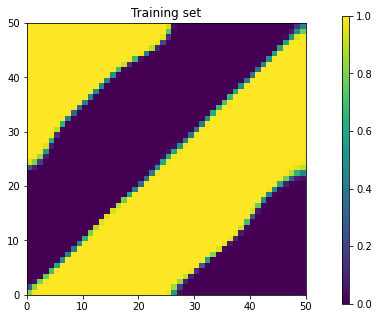

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.title('Training set')
plt.imshow(softmax(t.torch())[..., 0].detach().numpy().T, origin='lower', cmap='RdBu')